# Setup

In [331]:
import numpy as np
import pylab as plt
import scipy as sp
from scipy import linalg as LA
import scipy.optimize as opt
import scipy.stats as stats
from scipy.misc import derivative
import control as ctrl

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import copy
import pickle

from scipy.stats import norm
import statistics

# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)
def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

In [332]:

a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

In [350]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real

M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#scaling factors for output screen and input slider
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-350-5337dee7f6e3>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-350-5337dee7f6e3>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


## generate dr and ddr

In [334]:
# refs = dict(sos=sos,zer=zero)

# vector fields
vfs = ['so']
scaleOut = 0.8120629258740933

# restart random generator
seed = 49
np.random.seed(seed)

period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
#
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()
#
#print 'p_max = ',p_max,', primes[p_max] = ',primes[p_max]
amplitudes = dict([(vf,scaleOut*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
M = lambda s : 1/(s**2 + s) 
M_h_ = M(1.j*2*np.pi*frequencies_r['so'])
#d = Md/M
d = amplitudes_r['so'] / abs(M_h_)
amplitudes_d = amplitudes.copy()
amplitudes_d['so'] = d

#
num_refs = 15 # will generate double the number of refs
phase_shifts_r = dict([(vf,np.random.sample((num_refs,p_max[vf]))) for vf in vfs])

# only first disturbance signal differs from reference signals
#print phase_shifts_r
phase_shifts_d = copy.deepcopy(phase_shifts_r)
shiftedPhase = {}
for vf in vfs:
    phase_shifts_d[vf][:] = phase_shifts_d[vf][:]*.8

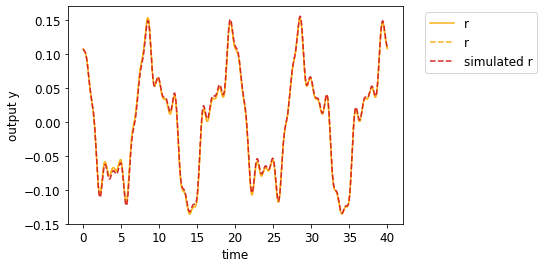

In [335]:
p = 0
c = 0
i = 9 #trial number

#empirical data (measured)
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivatives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 0
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

#initial cond
b = 1
x0 = np.array([r[0],dr[0]])
uFF = lambda t: b*dr[int(t/dt)] + ddr[int(t/dt)] #b*dr + ddr  

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))

# t_base,x_base = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=d)
  
t_,x_,u_ = numerical_simulation(so,T-dt*2,x0,t0=0.,dt=dt,ut=uFF,return_u=True)

plt.plot(t-5,ref*scaleOutputScreen,label='r',color= colors['r'])
plt.plot(t-5,r*scaleOutputScreen,'--',label='r',color= colors['r'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated r',color= colors['RED'])
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [336]:
#EO trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[1::2]
shift_id = 0
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

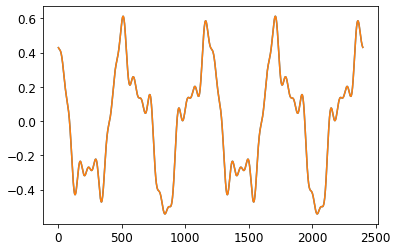

In [337]:
#OE trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[0::2]
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

plt.plot(r)
plt.plot(DATA['TIME']['subject'+str(0)]['condition'+str(0)]['r'][9]/scaleOutputScreen)

# LQG extended dim

## u1: finger force

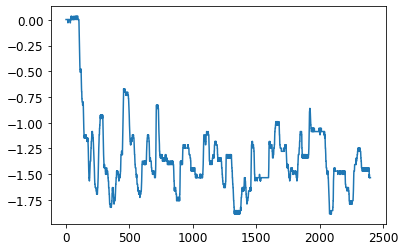

In [15]:
p = 10 #subject number
c = 2 #condition number
i = 13 #trial number
q1 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput #slider input
plt.plot(q1) 

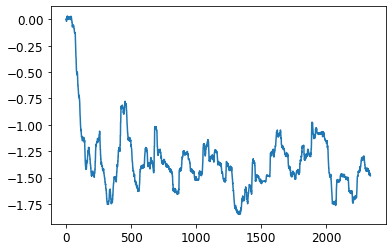

In [16]:
p = 10 #subject number
c = 2 #condition number
i = 13 #trial number
t_all = HCPS['subject0']['condition0']['trial0']['time_'] - 5

def rk_(f,t,x,dt):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

q1_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i][int(t/dt)]/scaleInput #slider input

dq1 = []
for j in t_all[:-61]:
    dq1.append(rk_(q1_fun,t=j,x=0,dt=1.))
plt.plot(dq1)

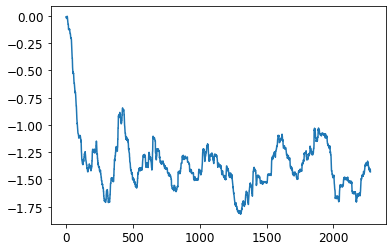

In [17]:
dq1_fun = lambda t,x: dq1[int(t/dt)]
ddq1 = []
for j in t_all[:-122]:
    ddq1.append(rk_(dq1_fun,t=j,x=0,dt=1.))
plt.plot(ddq1)

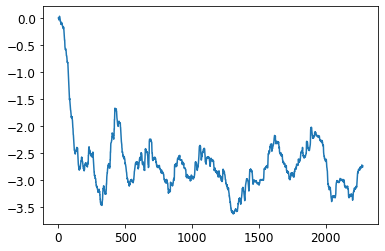

In [18]:
u1 = np.asarray(dq1[:-61]) + np.asarray(ddq1)  #finger force u1
plt.plot(u1)

## LQG sim

In [338]:
## 2-dim u (condition 2)
def rk_(f,t,x,dt=1.):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

p = 10 #subject number
c = 2 #condition number
i = 13 #trial number
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

In [339]:
#empirical dis
dis_ = np.concatenate(dis)
mean_d = statistics.mean(dis_)
sd_d = statistics.stdev(dis_)
var_d = statistics.variance(dis_)

# empirical delta from slider only condition0
delta_time_slider = avgdelta['avgdelta_time']['subject'+str(p)]['slider'] #time domain noise (from slider-only) for each participant
mean_delta_slider = statistics.mean(delta_time_slider)
sd_delta_slider = statistics.stdev(delta_time_slider)
var_delta_slider = statistics.variance(delta_time_slider)
# plt.plot(t,delta_time_slider)
# plt.show() 
# plt.hist(delta_time_slider,alpha=0.5,density=True,label = 'delta_slider',color=colors['d'])
# x_axis = np.arange(-0.3, 0.3, 1e-2)
# plt.plot(x_axis, norm.pdf(x_axis, mean_delta_slider, sd_delta_slider),label='delta_slider',color=colors['d'])
# plt.ylabel('frequency')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show() 

# empirical delta from emg only condition1
delta_time_emg = avgdelta['avgdelta_time']['subject'+str(p)]['emg'] #time domain noise (from emg-only) for each participant
mean_delta_emg = statistics.mean(delta_time_emg)
sd_delta_emg = statistics.stdev(delta_time_emg)
var_delta_emg = statistics.variance(delta_time_emg)
# plt.plot(t,delta_time_emg)
# plt.show() 
# plt.hist(delta_time_emg,alpha=0.5,density=True,label = 'delta_emg',color=colors['d'])
# x_axis = np.arange(-0.6, 0.6, 1e-2)
# plt.plot(x_axis, norm.pdf(x_axis, mean_delta_emg, sd_delta_emg),label='delta_emg',color=colors['d'])
# plt.ylabel('frequency')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show() 

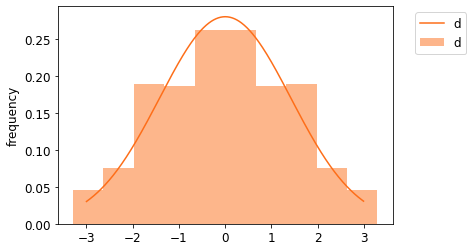

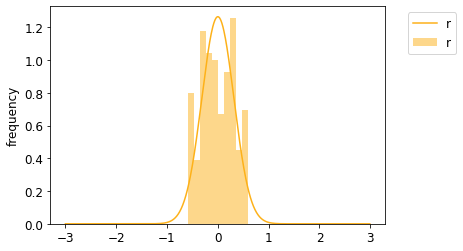

In [340]:
# bins=np.histogram(np.hstack((e_emgonly.flatten(),e_slideronly.flatten(),e_fusion50.flatten())), bins=50)[1] #get the bin edges
dis_ = np.concatenate(dis)
plt.hist(dis_,alpha=0.5,density=True,label = 'd',color=colors['d'])

# Calculating mean and standard deviation
x_axis = np.arange(-3, 3, 1e-2)
mean_d = statistics.mean(dis_)
sd_d = statistics.stdev(dis_)
var_d = statistics.variance(dis_)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='d',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

# Calculating mean and standard deviation
plt.hist(ref,alpha=0.5,density=True,label = 'r',color=colors['r'])
x_axis = np.arange(-3, 3, 1e-2)
mean_r = statistics.mean(ref)
sd_r = statistics.stdev(ref)
var_r = statistics.variance(ref)
plt.plot(x_axis, norm.pdf(x_axis, mean_r, sd_r),label='r',color=colors['r'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

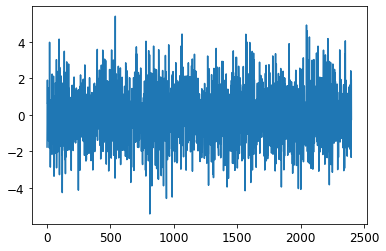

In [341]:
# mu, sigma = 0, sd_d # mean and standard deviation
s = np.random.normal(0, sd_d, N)
plt.plot(s)

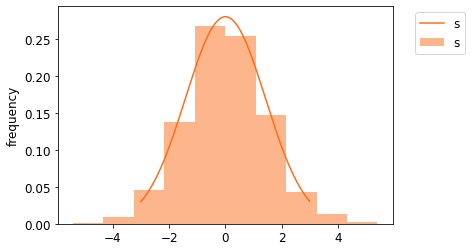

In [342]:
# Calculating mean and standard deviation
x_axis = np.arange(-3, 3, 1e-2)
# mean_s = statistics.mean(dis_)
# sd_s = statistics.stdev(dis_)
# var_s = statistics.variance(dis_)
plt.hist(s,alpha=0.5,density=True,label = 's',color=colors['d'])
plt.plot(x_axis, norm.pdf(x_axis, 0, sd_d),label='s',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [343]:
#need to update this to Mu_slider
q1 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput
q1_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i][int(t/dt)]/scaleInput #slider input

dq1 = []
for j in t_all[:-61]:
    dq1.append(rk_(q1_fun,t=j,x=0,dt=1.))
# plt.plot(dq1)


In [385]:
scaleInput

0.04616974606700115

In [439]:
n_state = 4
m_input = 2
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
weight = 0.5 #condition2 - 50% EMG
q1_weight = 100
#state x = [r-q,dr-dq]
A = np.array([[0, 1, 0, 0],[0, -b, weight, 0],[0, 0, 0, 1],[0, 0, 0, -b]])
B = np.array([[0, 0],[weight, 0],[0, 0],[0, 1]])
B_ = np.array([[0],[1],[0],[0]])
C = np.array([[1,0,0,0]]) #y = Cx is (r-q) 
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
# W = np.array([[0, 0],[0, var_d + 0.25*var_delta_emg + 0.25*var_delta_slider]])#cov of delta (input dis), assume no covariance(u,d)
# V = 1e-4 #cov of output distrubance 
# W = np.identity(n_state)
W = np.array([[0, 0, 0, 0],[0, var_d, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]])
V = 1e-4

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)
# K = copy.copy(K_)
# K[1] = K_[1]/scale

#empiriccal delta
delta0 = np.random.normal(mean_delta_emg, sd_delta_emg, size=N)*0 #from emg only
delta1 = np.random.normal(mean_delta_slider, sd_delta_slider, size=N)*0 #from slider only

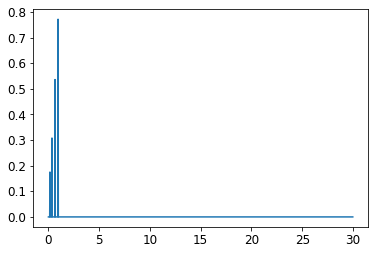

In [345]:
# dis_freq = np.angle( FFT(,N)[:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2]/scaleInput)
plt.plot(xf,D)
# plt.xlim((0,21*base_freq))

(0.0, 1.05)

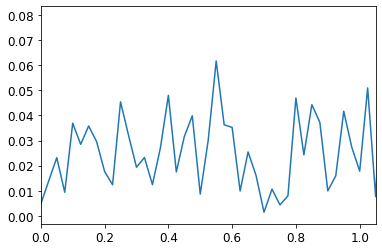

In [346]:
s_freq = np.abs( FFT(s,N)[:N//2] )
plt.plot(xf,s_freq)
plt.xlim((0,21*base_freq))

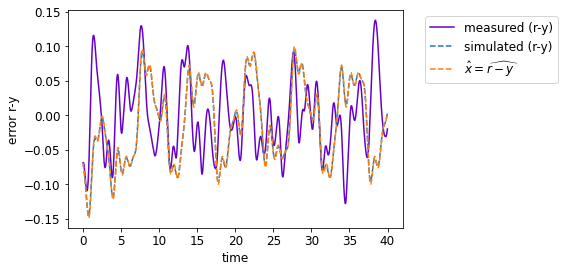

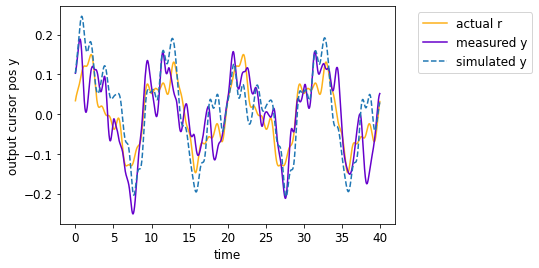

In [440]:
x0 = np.array([ry[0],dry0,-q1[0],-dq1[0]]) #(r-q,dr-dq)
# x0 = np.array([0,0,-q1[0],-dq1[0]]) #(r-q,dr-dq)
xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    # uff = -(b*dr[int(t/dt)] + ddr[int(t/dt)])
    # uFF = np.array([uff,uff])
    u_ = -np.dot(K,xh[-1])
    u = copy.copy(u_)
    # u[1] = u_[1]/scaleInput
    return u

def sys(t,x,u):
    # delta = np.array([delta0[int(t/dt)],delta1[int(t/dt)]])
    # uff = np.array(-(b*dr[int(t/dt)] + ddr[int(t/dt)]))
    dx = np.dot(A,x) + np.dot(B,u) - np.dot(B_,dis[int(t/dt)]) #+ np.dot(B_,uff).flatten() #+ np.dot(B,delta) #+ np.dot(B_,s[int(t/dt)]).flatten()
    y.append( np.dot(C,x) ) 
    dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1],dx[2],dx[3]))

t_,x_,u_ = numerical_simulation(sys,T-dt,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

plt.plot(t_,ry*scaleOutputScreen,label='measured (r-y)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-y)')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-y}$')

plt.xlabel('time')
plt.ylabel('error r-y') #ouput y = (r-q) is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output*scaleOutputScreen,label='measured y',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref)*scaleOutputScreen,'--',label='simulated y') #r'$simulated q= r_{actual}-(r-q)_{sim}$'

plt.xlabel('time')
plt.ylabel('output cursor pos y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [379]:
fingerscale = (max(u_[:,0])-min(u_[:,0])) /(max(q1)-min(q1))

In [380]:
fingerscale

0.40900983913787925

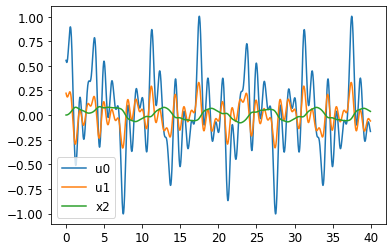

In [442]:
# Q1 =  FFT(u_[:,1],N) * M_h[:-1]
# Q1[0] = 1e-4
# q1 = IFFT(Q1,N)


plt.plot(t_[:-1],u_[:,0],label='u0') #arm force / EMG input
plt.plot(t_[:-1],u_[:,1],label='u1') #finger force
# plt.plot(t_[:-1],q1,label='q1') #slider input
plt.plot(t_[:-1],x_[:,2][:-1],label='x2') #slider input

# plt.plot( t_[:-1], weight*(u_[:,0] +q1) ) #equal weighted input
plt.legend()

## sim plots

In [360]:
p = 10 #subject number
c = 2 #condition number
i = 13 #trial number

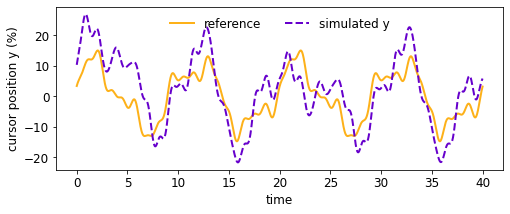

In [393]:
#simulated -(r-y) -ref ; compare to meausred y
plt.figure(figsize=(8, 3))
plt.plot(t_,100*ref*scaleOutputScreen,label='reference',color= colors['r'],linewidth=2,)
plt.plot(t_,100*(-x_[:,0] + ref)*scaleOutputScreen,'--',label='simulated y',color= colors['y'],linewidth=2)
plt.xlabel('time')
plt.ylabel('cursor position y (%)') #ouput y is that state q = x[:,0]
# plt.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=2, frameon=False)
plt.legend(loc='upper center', ncol=2, frameon=False)
# plt.savefig('output.png', dpi=300, bbox_inches='tight')
plt.show()

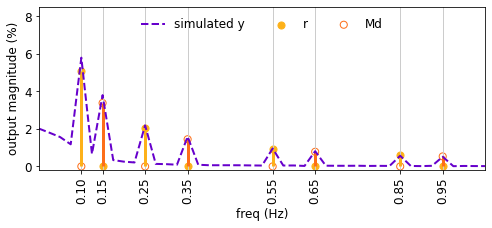

In [394]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
r = np.abs( FFT(ref*scaleOutputScreen,N)[:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
y_sim = np.abs( FFT((-x_[:,0] + ref)*scaleOutputScreen,N)[:N//2] )

plt.scatter(xf[stimulated_index],100*r[stimulated_index], color=colors['r'],label='r',s=50)
plt.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label='Md',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*r[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],color=colors['d'],linewidth = 3)

plt.plot(xf,100*y_sim,'--',label = 'simulated y',color = colors['y'],linewidth = 2)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,8.5))
plt.xlabel('freq (Hz)')
plt.ylabel('output magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
# plt.savefig('output freq.png', dpi=300, bbox_inches='tight')
plt.show()

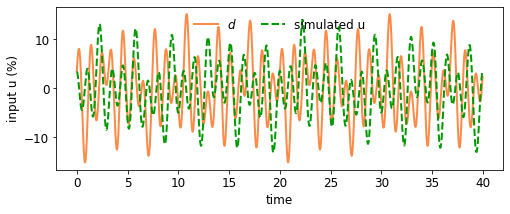

In [395]:
#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

#plot for presentation
plt.figure(figsize=(8, 3))
d = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]
plt.plot(t_[:-1],100*d[:-1],label=r'$d$',color= colors['d'],linewidth=2,alpha = 0.8)

u_total = -(weight*(u_[:,0] + q1)*scaleInput + uff[:-1]*scaleInput) # u = -(uFB + uFF)
plt.plot(t_[:-1],100*u_total,'--',label='simulated u',color= colors['u'],linewidth=2)

plt.xlabel('time')
plt.ylabel('input u (%)') #ouput y is that state q = x[:,0]
plt.legend(loc='upper center', ncol=2, frameon=False)
# plt.savefig('input.png', dpi=300, bbox_inches='tight')
plt.show()

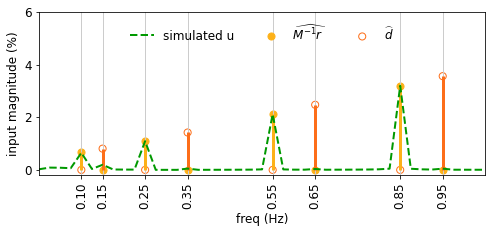

In [396]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
u_sim = np.abs( FFT( u_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 
# s_freq = np.abs(FFT( s*scaleInput,N )[:N//2])

plt.plot(xf,100*u_sim,'--',label = 'simulated u',color = colors['u'],linewidth = 2)
# plt.plot(xf,100*s_freq,label = 's',color = colors['d'],linewidth = 1)

plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,6))
plt.xlabel('freq (Hz)')
plt.ylabel('input magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
# plt.savefig('input freq.png', dpi=300, bbox_inches='tight')
plt.show()

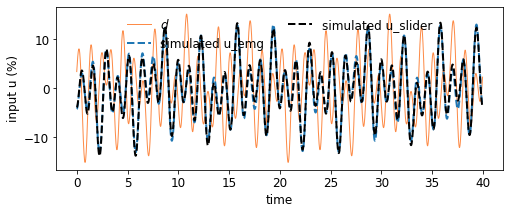

In [397]:
#plot for presentation
plt.figure(figsize=(8, 3))
d = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]

u0_total = -(u_[:,0]*scaleInput - uff[:-1]*scaleInput) # u = -(uFB + uFF)
u1_total = -(q1*scaleInput - uff[:-1]*scaleInput) # u = -(uFB + uFF)

plt.plot(t_[:-1],100*d[:-1],label=r'$d$',color= colors['d'],linewidth=1,alpha = 0.8)
plt.plot(t_[:-1],100*u0_total,'--',label='simulated u_emg',color= colors['BLUE'],linewidth=2)
plt.plot(t_[:-1],100*u1_total,'--',label='simulated u_slider',color= 'black',linewidth=2)

plt.xlabel('time')
plt.ylabel('input u (%)') #ouput y is that state q = x[:,0]
plt.legend(loc='upper center', ncol=2, frameon=False)
# plt.savefig('input.png', dpi=300, bbox_inches='tight')
plt.show()

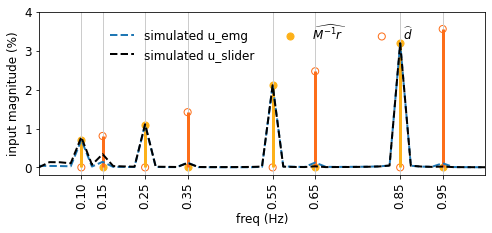

In [398]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
u0_sim = np.abs( FFT( u0_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 
# u1_sim = np.abs( FFT( (u_[:,1]+uff[:-2])*scaleInput ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) #finger force
q1_sim = np.abs( FFT( u1_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 

plt.plot(xf,100*u0_sim,'--',label = 'simulated u_emg',color = colors['BLUE'],linewidth = 2)
# plt.plot(xf,100*u1_sim,'--',label = 'simulated finger force',color = 'black',linewidth = 2)
plt.plot(xf,100*q1_sim,'--',label = 'simulated u_slider',color = 'black',linewidth = 2)

plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,4))
plt.xlabel('freq (Hz)')
plt.ylabel('input magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
# plt.savefig('input freq.png', dpi=300, bbox_inches='tight')
plt.show()

## func

In [8]:
# 2-dim u (condition 2)
def rk_(f,t,x,dt):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

n_state = 4
m_input = 2
b = 1
t_all = HCPS['subject0']['condition0']['trial0']['time_'] - 5
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
weight = 0.5 #condition2 - 50% EMG

#LQG of the fusion condition2
def LQG_SIM(p,c,i):   #subject number #condition number #trial number
    
    #empirical data (measured)
    ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
    dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
    input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
    output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
    ry = ref-output #r-y

    # #derivitives
    # sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
    # shift_id = i//2 #last trial 13
    # _t = np.asarray(t).copy(); _t.shape = (_t.size,1)
    # o = np.ones(_t.shape)
    # f = frequencies_r[vf][sines_r]
    # f = f.copy(); f.shape = (1,f.size)
    # a = amplitudes_r[vf][sines_r]
    # a = a.copy(); a.shape = (1,a.size)
    # _p = phase_shifts_r[vf][shift_id][sines_r]
    # _p = _p.copy(); _p.shape = (1,_p.size)
    # r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
    # dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
    # ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

    #find the derivative of the initial state with rk method
    ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
    dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)
    
    #empirical dis (mean, std, var)
    dis_ = np.concatenate(dis)
    mean_d = statistics.mean(dis_)
    sd_d = statistics.stdev(dis_)
    var_d = statistics.variance(dis_)

    # empirical delta (sensorimotor noise) from slider only condition0
    # delta_slider = np.zeros((N))
    # delta_slider[:len(avgdelta['subject'+str(p)]['slider'])] = copy.copy(avgdelta['subject'+str(p)]['slider'])
    # delta_slider[0] = 0
    # delta_time_slider = IFFT(delta_slider,N)/scaleInput
    delta_time_slider = avgdelta['avgdelta_time']['subject'+str(p)]['slider'] #time domain noise (from slider-only) for each participant
    mean_delta_slider = statistics.mean(delta_time_slider)
    sd_delta_slider = statistics.stdev(delta_time_slider)
    var_delta_slider = statistics.variance(delta_time_slider)

    # empirical delta (sensorimotor noise) from emg only condition1
    # delta_emg = np.zeros((N))
    # delta_emg[:len(avgdelta['subject'+str(p)]['emg'])] = copy.copy(avgdelta['subject'+str(p)]['emg'])
    # delta_emg[0] = 0
    # delta_time_emg = IFFT(delta_emg,N)/scaleInput
    delta_time_emg = avgdelta['avgdelta_time']['subject'+str(p)]['emg'] #time domain noise (from emg-only) for each participant
    mean_delta_emg = statistics.mean(delta_time_emg)
    sd_delta_emg = statistics.stdev(delta_time_emg)
    var_delta_emg = statistics.variance(delta_time_emg)

    #create Gaussian delta0 and delta1
    delta0 = np.random.normal(mean_delta_emg, sd_delta_emg, size=N) #from emg only
    delta1 = np.random.normal(mean_delta_slider, sd_delta_slider, size=N) #from slider only

    # LQG of fusion condition
    A = np.array([[0, 1],[0, -b]])
    B = np.array([[0, 0],[weight, weight]])
    B_ = np.array([[0],[1]])
    C = np.array([[1,0]])
    Q = np.identity(n_state) # running state cost
    R = np.identity(m_input) # running control cost
    W = np.array([[0, 0],[0, var_d + (weight**2)*var_delta_emg + (weight**2)*var_delta_slider]])#cov of delta (input dis), assume no covariance(u,d)
    # W = np.array([[0,0],[0,1e-4]])
    V = 1e-4 #cov of output distrubance 
    K,_,_ = ctrl.lqr(A,B,Q,R)
    L,_,_ = ctrl.lqr(A.T,C.T,W,V)

    #initial state
    x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
    xh = [x0]
    y = [x0[0]]

    def uFF_FB(t,x):
        # uff = b*dr[int(t/dt)] + ddr[int(t/dt)]
        # uFF = np.array([uff,uff])
        u = -np.dot(K,xh[-1])
        return u

    def sys(t,x,u):
        delta = np.array([delta0[int(t/dt)],delta1[int(t/dt)]])
        dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,delta) - np.dot(B_,dis[int(t/dt)])
        y.append( np.dot(C,x) ) #no eta
        dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
        xh.append( xh[-1] + dxh*dt )
        return np.hstack((dx[0],dx[1]))

    t_,x_,u_ = numerical_simulation(sys,T-dt,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

    return t_,x_,u_,xh

In [9]:
c = 2 #condition number
i = 13 #trial number
x_all = []
u_all = []
xh_all = []

out_all = []
out0_all = []
out1_all = []

in_all = []
in0_all = []
in1_all = []

for p in range(participants_num): #subject number
    t_,x_,u_,xh = LQG_SIM(p,c,i)
    x_all.append(x_) #simulated
    u_all.append(u_) #simulated
    xh_all.append(xh) #simulated (estimation x)
    out_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen ) #measured
    out0_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y0'][i]/scaleOutputScreen ) #measured
    out1_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y1'][i]/scaleOutputScreen ) #measured

    in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
    in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
    in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured


In [10]:
#sim data
x_all_mean = np.mean(x_all, axis=0)
u_all_mean = - np.mean(u_all, axis=0) #this is "-u" because u was measured in error coordinates, i.e. -uFB-uFF

#measured data
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
out_all_mean = np.mean(out_all, axis=0)
out_all_75 = np.percentile(out_all, 75, axis=0)
out_all_25 = np.percentile(out_all, 25, axis=0)
out0_all_mean = np.mean(out0_all, axis=0)
out0_all_75 = np.percentile(out0_all, 75, axis=0)
out0_all_25 = np.percentile(out0_all, 25, axis=0)
out1_all_mean = np.mean(out1_all, axis=0)
out1_all_75 = np.percentile(out1_all, 75, axis=0)
out1_all_25 = np.percentile(out1_all, 25, axis=0)

in_all_mean = np.mean(in_all, axis=0)
in_all_75 = np.percentile(in_all, 75, axis=0)
in_all_25 = np.percentile(in_all, 25, axis=0)
in0_all_mean = np.mean(in0_all, axis=0)
in0_all_75 = np.percentile(in0_all, 75, axis=0)
in0_all_25 = np.percentile(in0_all, 25, axis=0)
in1_all_mean = np.mean(in1_all, axis=0)
in1_all_75 = np.percentile(in1_all, 75, axis=0)
in1_all_25 = np.percentile(in1_all, 25, axis=0)